In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime

# Functions

In [3]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [4]:
def get_mrat(dataframe,numerator=21,denominator=200):

    mrat=(dataframe.rolling(numerator).mean()/dataframe.rolling(denominator).mean())
    mrat_wo_na=mrat.dropna(how='all')

    month=list(sorted(set(mrat_wo_na.index + pd.offsets.BMonthEnd(0))))
    #month_end=pd.to_datetime(mrat_wo_na.index)
    month = pd.to_datetime(month)

    idx1 = pd.Index(mrat_wo_na.iloc[:-1].index)
    idx2 = pd.Index(month)
    closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]


    mrat_weights=mrat_wo_na.loc[closest_dates].copy().fillna(0)
    
    mrat_weights['Total']=mrat_weights.sum(axis=1)

    for col in mrat_weights.columns:
        mrat_weights[col]=mrat_weights[col]/mrat_weights['Total']

    mrat_weights=mrat_weights.drop(columns='Total')
    mrat_weights_dict=mrat_weights.transpose().to_dict()

    dates_end=list(mrat_weights.index)
    dates_end.insert(0,dataframe.index[0])
    dates_end.append(dataframe.index[-1])
    dates_end=list(set(dates_end))
    
    return mrat_weights,sorted(dates_end)

In [5]:
def get_portfolios(mrat_weights,dates_end,dataframe,weight_dict,
                   numbers_of_stocks=50,
                   investment_amount=10000,
                   transaction_fee=0.005):
    tracking={}
    portfolio={}
    initial_amount=investment_amount
    perf=dataframe.pct_change()
    
    for i in range(len(dates_end)-1):
        
        print(dates_end[i],investment_amount,investment_amount/initial_amount)

        
        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
        initial_price=temp.iloc[0].to_dict()

        if dates_end[i]>dates_end[0]:

            top=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:numbers_of_stocks]
            top_rebased=top/top.sum()
            top_dict=top_rebased.to_dict()

            weight_dict={}

            for key in temp.columns:

                if key in top_dict: 
                    weight_dict[key]=top_dict[key]
                else:
                    weight_dict[key]=0
                    
                    
        weight_vec=np.array(list(weight_dict.values()))
        
        inital_investment_per_stock={}
        shares={}

        for col in temp.columns:
            
            weighted_perf=weight_vec*perf.loc[dates_end[i]]
            
            inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
            shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

        tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

        temp=temp*shares    
        portfolio[dates_end[i]]=temp
        investment_amount=temp.iloc[-1].sum()
        
    
    temp=dataframe.loc[dates_end[-2]:]*shares
    portfolio[dates_end[-1]]=temp
        

    return portfolio,tracking


In [6]:
def get_pnl(portfolios):

    pnl={}

    keys=list(portfolio.keys())
    for i in range(0,len(keys)):

        if i>0:
            pnl[keys[i]]=portfolio[keys[i]].iloc[-1]-portfolio[keys[i]].iloc[0]

        else:
            
            pnl[keys[0]]=portfolio[keys[0]].iloc[-1]-portfolio[keys[0]].iloc[0]
    
    pnl_dataframe=pd.DataFrame(pnl).T.iloc[4:].cumsum(axis=0)
    
    return pnl_dataframe.iloc[:-2]

# Dataset

In [8]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
#url='https://en.wikipedia.org/wiki/CAC_40'
table = pd.read_html(url)
df = table[0]

In [9]:
tickers=df['Symbol'].tolist()

In [10]:
# marketcap_dico={}
# for ticker in tickers:
#     try:

#         ticker_data = yf.Ticker(ticker)
#         current_market_cap = ticker_data.info['marketCap']
#         marketcap_dico[ticker]=current_market_cap
#     except:
#         print('Error with: ', ticker)

In [11]:
# market_cap=pd.read_excel('Market Cap.xlsx',index_col=0)

# tickers=list(market_cap.sort_values(by='Market Cap',ascending=False).iloc[:500].index)

# pd.DataFrame(marketcap_dico.values(),index=marketcap_dico.keys(),columns=['Market Cap']).to_excel('Market Cap.xlsx')

In [12]:
# tickers.remove('PLTR')
# tickers.remove('SMCI')
# tickers.remove('UBER')
# tickers.remove('CRWD')

In [13]:
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.datetime(2019,6,15)).strftime("%Y-%m-%d")

dataframe=get_close(tickers,start=start_date,end=end_date)
dataframe.index=pd.to_datetime(dataframe.index)

$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2019-06-15 -> 2025-02-23)


In [14]:
#with_no_na=dataframe.columns[np.where((dataframe.isna().sum()<30))]

In [15]:
#dataframe=dataframe[with_no_na]

In [16]:
sp500=get_close(['SPY'],start=start_date,end=end_date)
sp500_leverage=get_close(['XS2D.L'],start=start_date,end=end_date)

# Analysis

In [18]:
weight_dict={col: 1/dataframe.shape[1] for col in dataframe.columns}
mrat_weights,dates_end=get_mrat(dataframe,numerator=21,denominator=200)

In [19]:
mrat_weights = mrat_weights[~mrat_weights.index.duplicated(keep='first')]

In [20]:
portfolio,tracking=get_portfolios(investment_amount=100,dataframe=dataframe,numbers_of_stocks=15,weight_dict=weight_dict,
                                  mrat_weights=mrat_weights,dates_end=dates_end,
                                  transaction_fee=0.005)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13092\3430555856.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


2019-06-17 00:00:00 100 1.0
2020-03-31 00:00:00 83.91795122395119 0.8391795122395119
2020-04-30 00:00:00 100.52887257815283 1.0052887257815284
2020-05-29 00:00:00 108.91876888394427 1.0891876888394427
2020-06-30 00:00:00 116.52859795746953 1.1652859795746953
2020-07-31 00:00:00 133.40070680292104 1.3340070680292104
2020-08-31 00:00:00 148.46640087110123 1.4846640087110123
2020-09-30 00:00:00 145.50281093867562 1.4550281093867563
2020-10-30 00:00:00 143.2318327894594 1.432318327894594
2020-11-30 00:00:00 164.74025358237824 1.6474025358237825
2020-12-31 00:00:00 174.18327222392298 1.7418327222392298
2021-01-29 00:00:00 183.20349501851177 1.8320349501851176
2021-02-26 00:00:00 197.88475596143255 1.9788475596143256
2021-03-31 00:00:00 193.455550224207 1.93455550224207
2021-04-30 00:00:00 199.00063167860804 1.9900063167860804
2021-06-01 00:00:00 207.2991011738257 2.072991011738257
2021-06-30 00:00:00 206.9792300425806 2.069792300425806
2021-07-30 00:00:00 208.8582843790395 2.088582843790395

In [21]:
pd.DataFrame(tracking[dates_end[-2]][0].items()).set_index(0).sort_values(by=1,ascending=False).iloc[:20]

,1
0,
PLTR,0.095369
TPR,0.071601
UAL,0.071149
GEV,0.068534
AXON,0.067821
VST,0.067407
TSLA,0.064145
TPL,0.062728
FFIV,0.062708


In [22]:
dates_end[-3]

Timestamp('2025-01-31 00:00:00')

In [23]:
investment_amount=100
shares={}
for col in dataframe:
    
    shares[col]=(weight_dict[col]*investment_amount)/dataframe.iloc[0][col]

In [24]:
equal_weight=shares*dataframe

In [25]:
pnl=get_pnl(portfolio)

In [26]:
pnl['Total']=pnl.sum(axis=1)
pnl_pct=pnl.copy()

for col in pnl_pct.columns:
    pnl_pct[col]/=pnl_pct['Total']
    
pnl_contrib=pd.DataFrame(pnl_pct.iloc[-1].sort_values(ascending=False))
pnl_amount=pd.DataFrame(pnl.iloc[-1].sort_values(ascending=False))

In [87]:
pnl_contrib[pnl_contrib.columns[0]]

Total    1.000000
PLTR     0.128226
NVDA     0.097715
SMCI     0.094337
VST      0.069569
           ...   
WBD     -0.010377
NCLH    -0.010800
UHS     -0.012055
AMD     -0.018021
CCL     -0.018550
Name: 2025-01-31 00:00:00, Length: 502, dtype: float64

In [28]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])
    

C:\Users\Admin\AppData\Local\Temp\ipykernel_13092\89254820.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  performance_pct=performance_pct.pct_change()


<Axes: >

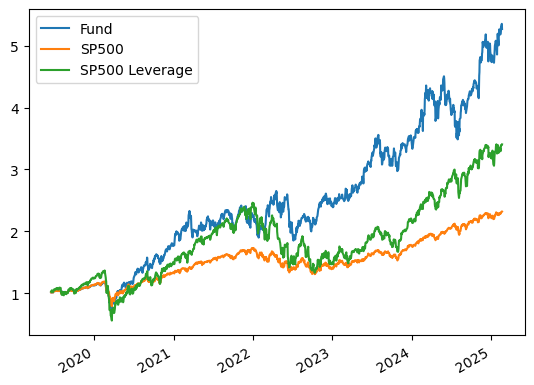

In [29]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['SP500']=sp500
#performance['Equal Weight']=equal_weight.sum(axis=1)
performance['SP500 Leverage']=sp500_leverage

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [30]:
years=sorted(list(set(performance.index.year)))

In [31]:
month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

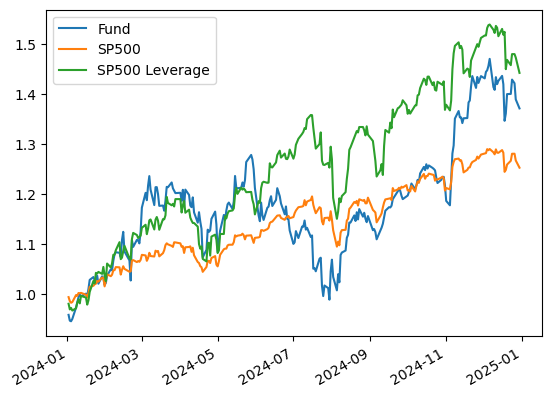

In [32]:
(1+performance_pct.loc[str(2024)].iloc[:-1]).cumprod().plot()

In [33]:
year_returns={}
year_returns[years[0]]=performance.loc[str(years[0])].iloc[-1]/performance.loc[str(years[0])].iloc[0]-1
for i in range(len(years)-1):

    perf_year=performance.loc[str(years[i+1])].iloc[-1]/performance.loc[str(years[i])].iloc[-1]-1
    year_returns[years[i+1]]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-2])].iloc[-1]-1

In [34]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2019,2020,2021,2022,2023,2024,2025
Fund,0.125370,0.590486,0.246125,0.086979,0.452968,0.358494,0.045675
SP500,0.128370,0.183317,0.287288,-0.181754,0.261758,0.248865,0.041462
SP500 Leverage,0.232929,0.209603,0.630291,-0.390880,0.488736,0.456542,0.049770


In [35]:
month_returns={}
month_returns[month_year[0]]=performance.loc[str(month_year[0])].iloc[-1]/performance.loc[str(month_year[0])].iloc[0]-1
for i in range(len(month_year)-1):

    perf_year=performance.loc[str(month_year[i+1])].iloc[-1]/performance.loc[str(month_year[i])].iloc[-1]-1
    month_returns[month_year[i+1]]=perf_year

month_returns[month_year[-1]]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-2])].iloc[-1]-1

In [36]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
Fund,0.023039,0.014254,-0.018219,0.020776,0.014085,0.038451,0.027664,-0.003205,-0.080928,-0.163584,...,0.064001,-0.070146,-0.072410,0.105631,0.034117,0.018560,0.179329,-0.05444,0.071064,-0.023704
SP500,0.017469,0.015120,-0.016743,0.019458,0.022105,0.036198,0.029055,-0.000404,-0.079166,-0.124871,...,0.050580,0.035280,0.012109,0.023365,0.021005,-0.008924,0.059633,-0.02406,0.026856,0.014224
SP500 Leverage,0.026310,0.055038,-0.066508,0.042734,0.032491,0.079948,0.049103,0.007700,-0.194302,-0.237840,...,0.045579,0.111924,0.004436,0.018661,0.044609,-0.006738,0.105126,-0.03740,0.056020,-0.005919


In [37]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500'].iloc[-2]/performance['SP500'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(dataframe.index.year)))/metrics['Fund Vol']

In [38]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.474208
Fund Vol,0.520368
Bench Vol,0.202207
Fund Return,5.004010
Bench Return,2.308059
Sharpe Ratio,2.482535


In [39]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500 Leverage']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500 Leverage'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500 Leverage'].iloc[-2]/performance['SP500 Leverage'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(dataframe.index.year)))/metrics['Fund Vol']

In [40]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.544976
Fund Vol,0.520368
Bench Vol,0.361859
Fund Return,5.004010
Bench Return,3.371194
Sharpe Ratio,2.482535


In [41]:
shares=pd.DataFrame()
for date in dates_end[:-1]:
    shares[date]=tracking[date][1]
shares=shares.T

In [42]:
positions=pd.DataFrame()
positions.index=dataframe.index
positions=pd.concat([positions,shares],axis=1)
positions=positions.ffill()

In [43]:
#dataframe.iloc[:-1].to_excel('SP500 Prices.xlsx')
#positions[:-1].to_excel('Rebalancing.xlsx')